<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoostRegression" data-toc-modified-id="CatBoostRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoostRegression</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

__Загрузка библиотек__

In [1]:
import time
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit

warnings.filterwarnings('ignore')

__Функции, которые будут использоваться в проекте__

In [2]:
def num_func(data):
    numeric_cols = data.select_dtypes(include='number').columns

    num_plots = len(numeric_cols)
    plt.figure(figsize=(10, 5 * num_plots))
    
    for i, col in enumerate(numeric_cols):
        plt.subplot(num_plots, 2, 2*i + 1)
        df[col].hist(bins=15)
        plt.title(f'Гистограмма для {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.subplot(num_plots, 2, 2*i + 2)
        df.boxplot(column=col)
        plt.title(f'Диаграмма размаха {col}')
        
    plt.tight_layout()
    plt.show()

In [3]:
def data_exploration_func(data):
    print('=========================')
    print('Датасет', data.name)
    display(data.head(10))
    data.info()
    display(data.describe(include='all')) 

In [4]:
def get_features(data_learning):
    data_learning['month'] = data_learning.index.month
    data_learning['day'] = data_learning.index.day
    data_learning['dayofweek'] = data_learning.index.dayofweek
    data_learning['hour'] = data_learning.index.hour
    
    for lag in range(1, 6):
        data_learning['lag_{}'.format(lag)] = data_learning['num_orders'].shift(lag)
    
    data_learning['rolling_mean'] = data_learning['num_orders'].shift().rolling(1).mean()
    data_learning.dropna(inplace=True)
    
    return data_learning

In [5]:
def lineplot(data, title):
    data.plot()
    plt.title(title)
    plt.show()

In [6]:
def display_result(target, pred, rmse, model_name):
    
    result = target.to_frame().reset_index()
    result['prediction'] = pd.Series(pred)
    result.set_index('datetime', inplace=True)

    fig = go.Figure(layout=dict(title=dict(text=model_name)))
    fig.add_trace(go.Scatter(x=result.index, y=result[target.name], name='True'))
    fig.update_xaxes(title_text='Время (дни)')
    fig.update_yaxes(title_text='Количество заказов')
    fig.add_trace(go.Scatter(x=result.index, y=result['prediction'], name='Predicted'))
    display(fig)

__Константа__

In [7]:
RANDOM_STATE=42

## Подготовка

In [8]:
try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0]) 
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [9]:
data.name = "taxi"

In [10]:
data_exploration_func(data)

Датасет taxi


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

Проверим на количество пропусков

In [11]:
data.isna().sum()

num_orders    0
dtype: int64

Проверим на наличие дубликатов

In [12]:
data.duplicated().sum()

26415

Проверим, в хронологическом ли порядке расположены даты и время, посмотрим на атрибут индекса таблицы is_monotonic. Если порядок соблюдён, атрибут вернёт True, если нет — False.

In [13]:
data.index.is_monotonic

True

Выполним ресемплирование, т.е. измененим интервал со значениями ряда. Выберем интервал в один час, а по каждой группе — вычислим суммарное значение.

In [14]:
data = data.resample('1H').sum()

__Вывод:__
Данные были успешно считаны и содержат один столбец - num_orders, без пропусков и отклонений в статистике. Временные дубликаты отсутствуют. Данные отсортированы и преобразованы во временной ряд, проверена его монотонность. Выполнено ресемплирование с интервалом в один час с функцией суммирования. Даты и время в датафрейме расположены хронологически, что подтверждает корректность предварительной обработки данных. Теперь данные готовы для обучения моделей.

## Анализ

Построим временной ряд количества заказов.

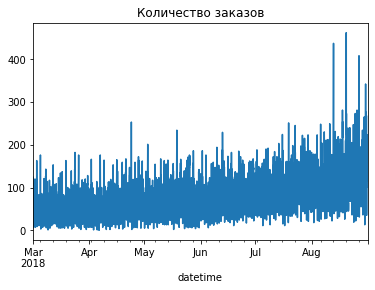

In [15]:
lineplot(data['num_orders'], 'Количество заказов')

Временной ряд на графике имеет множественные колебания, потому что у него меняется среднее значение.

Разделим данные на трендовую, сезонную и шумовую состовляющие и построим соответствующие графики

In [16]:
decomposed = seasonal_decompose(data)

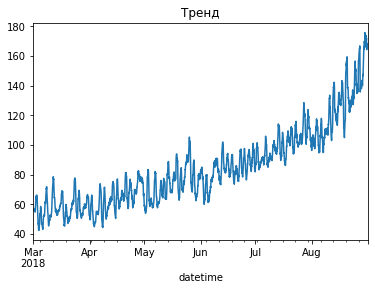

In [17]:
lineplot(decomposed.trend, 'Тренд')

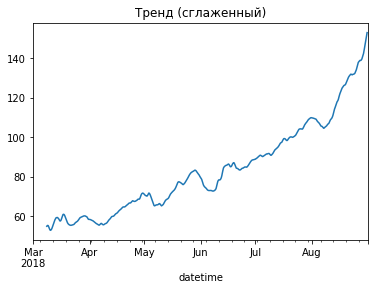

In [18]:
lineplot(decomposed.trend.rolling(24*7).mean(), 'Тренд (сглаженный)')

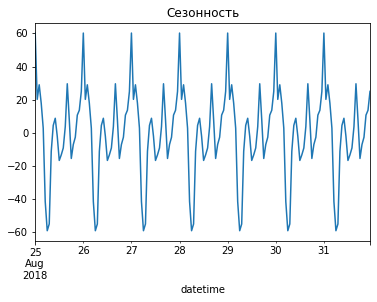

In [19]:
lineplot(decomposed.seasonal.tail(24*7), 'Сезонность')

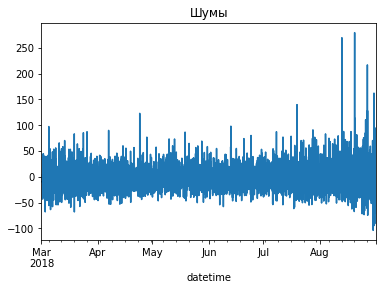

In [20]:
lineplot(decomposed.resid, 'Шумы')

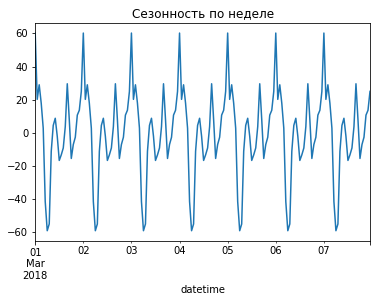

In [21]:
lineplot(decomposed.seasonal['2018-03-01':'2018-03-7'], 'Сезонность по неделе')

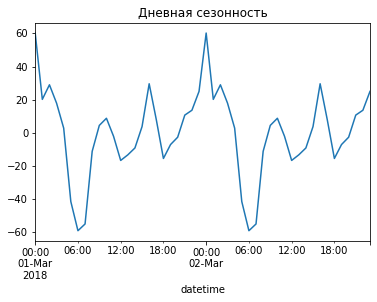

In [22]:
lineplot(decomposed.seasonal['2018-03-01':'2018-03-2'], 'Дневная сезонность')

__Вывод:__
- Наблюдается общий тренд равномерного роста количества заказов с периодическими небольшими падениями. Это может указывать на постепенное увеличение спроса или развитие бизнеса в данной области.
- Присутствует выраженная сезонность по времени суток: минимум заказов наблюдается в ночное время, затем количество заказов возрастает с утра и в течение дня, достигая пика к вечеру.
- Временной ряд имеет множественные колебания и не является стационарным, однако разности временного ряда стационарны.
- Разложение временного ряда показало положительный линейный тренд на протяжении года, а также наличие шума в данных.
- Анализ сезонности на интервале в неделю выявил циклично-повторяющиеся закономерности: рост количества заказов происходит в одинаковые часы каждый день, с пиком вечером, за исключением воскресенья, когда пик немного ниже.

## Обучение

Создадим признаки для горизонта прогнозирования в один шаг при помощи функции _get_features()_

In [86]:
train_models = []
train_models_name = ['Linear Regression', 'CatBoostRegressor', 'LightGBM', 'DecisionTreeRegressor']
rmse_train = []
tscv = TimeSeriesSplit(n_splits=5)

In [87]:
data_learning = data.copy()
get_features(data_learning)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,43.0
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,6.0
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,12.0
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,15.0
2018-03-01 09:00:00,69,3,1,3,9,34.0,15.0,12.0,6.0,43.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,207.0
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,136.0
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,154.0


In [88]:
X = data_learning.drop(['num_orders'], axis=1)
y = data_learning['num_orders']

Разделим данные на обучающую и тестовую выборки

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    shuffle=False, 
                                                    test_size=0.1, 
                                                    random_state=RANDOM_STATE)

### LinearRegression

In [90]:
model_lr = LinearRegression()

model_lr.fit(X_train, y_train)

predictions_lr = model_lr.predict(X_train)

In [91]:
rmse = mean_squared_error(y_train, predictions_lr, squared=False)
print("RMSE LinearRegression: %.2f" % rmse)
rmse_train.append(rmse)
train_models.append([model_lr, rmse])

RMSE LinearRegression: 30.49


### CatBoostRegression

In [92]:
train_pool = Pool(X_train, 
                  y_train)

test_pool = Pool(X_test)

In [93]:
params_cat = {'learning_rate': [0.05, 1],
              'depth': [5, 10]
              }

model_catboost = CatBoostRegressor(iterations=100,
                                   loss_function='RMSE',
                                   random_state=RANDOM_STATE)

gscb = GridSearchCV(model_catboost, 
                    params_cat, 
                    cv=tscv,
                    scoring='neg_mean_squared_error')

gscb.fit(X_train, y_train)

0:	learn: 28.9194957	total: 778us	remaining: 77ms
1:	learn: 28.2166699	total: 1.59ms	remaining: 77.9ms
2:	learn: 27.6355621	total: 2.17ms	remaining: 70.1ms
3:	learn: 27.2261300	total: 2.8ms	remaining: 67.3ms
4:	learn: 26.6653095	total: 3.48ms	remaining: 66.2ms
5:	learn: 26.1130798	total: 4.13ms	remaining: 64.7ms
6:	learn: 25.7568859	total: 4.77ms	remaining: 63.4ms
7:	learn: 25.4169552	total: 5.44ms	remaining: 62.5ms
8:	learn: 24.9473432	total: 6.12ms	remaining: 61.9ms
9:	learn: 24.5375523	total: 6.71ms	remaining: 60.4ms
10:	learn: 24.1948076	total: 7.23ms	remaining: 58.5ms
11:	learn: 23.8171322	total: 7.74ms	remaining: 56.8ms
12:	learn: 23.4335607	total: 8.75ms	remaining: 58.5ms
13:	learn: 23.0713052	total: 9.69ms	remaining: 59.5ms
14:	learn: 22.7445548	total: 10.6ms	remaining: 59.9ms
15:	learn: 22.4273636	total: 11.6ms	remaining: 61ms
16:	learn: 22.2354789	total: 12.7ms	remaining: 62ms
17:	learn: 21.9912276	total: 13.6ms	remaining: 61.9ms
18:	learn: 21.7953480	total: 14.5ms	remaining:

0:	learn: 31.2480920	total: 1.19ms	remaining: 118ms
1:	learn: 30.6096313	total: 2.25ms	remaining: 110ms
2:	learn: 30.0355834	total: 3.37ms	remaining: 109ms
3:	learn: 29.5203363	total: 4.37ms	remaining: 105ms
4:	learn: 29.0306836	total: 5.27ms	remaining: 100ms
5:	learn: 28.6261059	total: 6.15ms	remaining: 96.4ms
6:	learn: 28.1758711	total: 7.03ms	remaining: 93.4ms
7:	learn: 27.8586333	total: 7.89ms	remaining: 90.8ms
8:	learn: 27.4567259	total: 8.73ms	remaining: 88.3ms
9:	learn: 27.1280408	total: 9.64ms	remaining: 86.8ms
10:	learn: 26.8895177	total: 10.7ms	remaining: 86.4ms
11:	learn: 26.6736474	total: 11.6ms	remaining: 85.1ms
12:	learn: 26.4592992	total: 12.5ms	remaining: 83.8ms
13:	learn: 26.1805509	total: 13.5ms	remaining: 82.7ms
14:	learn: 25.8690419	total: 14.3ms	remaining: 81.2ms
15:	learn: 25.6873536	total: 15.3ms	remaining: 80.1ms
16:	learn: 25.4226316	total: 16.2ms	remaining: 78.9ms
17:	learn: 25.2239658	total: 17.1ms	remaining: 77.8ms
18:	learn: 25.0365445	total: 17.9ms	remaini

0:	learn: 34.0490154	total: 1.43ms	remaining: 142ms
1:	learn: 33.3928239	total: 2.71ms	remaining: 133ms
2:	learn: 32.7577669	total: 3.91ms	remaining: 126ms
3:	learn: 32.1149598	total: 5.02ms	remaining: 120ms
4:	learn: 31.5641836	total: 6.24ms	remaining: 119ms
5:	learn: 31.0130320	total: 7.41ms	remaining: 116ms
6:	learn: 30.5344813	total: 8.55ms	remaining: 114ms
7:	learn: 30.1141569	total: 9.73ms	remaining: 112ms
8:	learn: 29.6469933	total: 10.8ms	remaining: 109ms
9:	learn: 29.2868099	total: 12ms	remaining: 108ms
10:	learn: 28.9621515	total: 13.2ms	remaining: 107ms
11:	learn: 28.5667457	total: 14.4ms	remaining: 106ms
12:	learn: 28.3120030	total: 15.6ms	remaining: 104ms
13:	learn: 28.0704450	total: 16.7ms	remaining: 103ms
14:	learn: 27.6990016	total: 17.9ms	remaining: 101ms
15:	learn: 27.4241518	total: 19ms	remaining: 100ms
16:	learn: 27.1077423	total: 20.1ms	remaining: 98.2ms
17:	learn: 26.8302806	total: 21.2ms	remaining: 96.5ms
18:	learn: 26.5820071	total: 22.3ms	remaining: 95.2ms
19:	

0:	learn: 23.2143686	total: 981us	remaining: 97.1ms
1:	learn: 21.6350162	total: 1.96ms	remaining: 96.1ms
2:	learn: 20.9112088	total: 2.78ms	remaining: 90ms
3:	learn: 19.9786440	total: 3.65ms	remaining: 87.6ms
4:	learn: 19.1809145	total: 4.4ms	remaining: 83.7ms
5:	learn: 18.5322887	total: 5.16ms	remaining: 80.8ms
6:	learn: 18.0965353	total: 5.96ms	remaining: 79.1ms
7:	learn: 17.7216055	total: 6.79ms	remaining: 78.1ms
8:	learn: 17.2621205	total: 7.63ms	remaining: 77.2ms
9:	learn: 17.2234534	total: 8.3ms	remaining: 74.7ms
10:	learn: 16.7449326	total: 9.06ms	remaining: 73.3ms
11:	learn: 16.3132702	total: 9.81ms	remaining: 71.9ms
12:	learn: 15.7875610	total: 10.5ms	remaining: 70.5ms
13:	learn: 15.4832644	total: 11.3ms	remaining: 69.2ms
14:	learn: 15.2219645	total: 12.1ms	remaining: 68.4ms
15:	learn: 15.1470591	total: 13ms	remaining: 68ms
16:	learn: 14.9865390	total: 13.7ms	remaining: 66.9ms
17:	learn: 14.8346297	total: 14.5ms	remaining: 65.9ms
18:	learn: 14.5939060	total: 15.3ms	remaining: 

0:	learn: 24.7018208	total: 1.16ms	remaining: 115ms
1:	learn: 22.8120158	total: 2.39ms	remaining: 117ms
2:	learn: 21.8517127	total: 3.51ms	remaining: 113ms
3:	learn: 21.4535412	total: 4.52ms	remaining: 109ms
4:	learn: 20.8240937	total: 5.57ms	remaining: 106ms
5:	learn: 20.2605750	total: 6.74ms	remaining: 106ms
6:	learn: 19.9196153	total: 7.71ms	remaining: 102ms
7:	learn: 19.7609916	total: 8.72ms	remaining: 100ms
8:	learn: 19.4192143	total: 9.7ms	remaining: 98ms
9:	learn: 19.1705719	total: 10.8ms	remaining: 97.3ms
10:	learn: 18.8000519	total: 11.9ms	remaining: 96.1ms
11:	learn: 18.7389698	total: 12.9ms	remaining: 94.3ms
12:	learn: 18.5642485	total: 13.9ms	remaining: 93.2ms
13:	learn: 18.4894512	total: 15ms	remaining: 92ms
14:	learn: 18.2705679	total: 16ms	remaining: 90.5ms
15:	learn: 17.9790617	total: 17ms	remaining: 89.3ms
16:	learn: 17.7580767	total: 18.1ms	remaining: 88.6ms
17:	learn: 17.4910029	total: 19.3ms	remaining: 87.8ms
18:	learn: 17.2013153	total: 20.2ms	remaining: 86.3ms
19:

0:	learn: 28.9664219	total: 8.49ms	remaining: 841ms
1:	learn: 28.3191065	total: 16.7ms	remaining: 817ms
2:	learn: 27.6594053	total: 24.3ms	remaining: 787ms
3:	learn: 27.0335350	total: 32.1ms	remaining: 771ms
4:	learn: 26.5240087	total: 40.3ms	remaining: 766ms
5:	learn: 26.0476063	total: 48.5ms	remaining: 759ms
6:	learn: 25.4773851	total: 56.5ms	remaining: 751ms
7:	learn: 25.0030360	total: 64.5ms	remaining: 742ms
8:	learn: 24.5245007	total: 72.7ms	remaining: 735ms
9:	learn: 24.1051096	total: 80.8ms	remaining: 727ms
10:	learn: 23.6417398	total: 88.6ms	remaining: 717ms
11:	learn: 23.2243188	total: 96.8ms	remaining: 710ms
12:	learn: 22.8956688	total: 105ms	remaining: 701ms
13:	learn: 22.5553091	total: 113ms	remaining: 693ms
14:	learn: 22.1865618	total: 121ms	remaining: 687ms
15:	learn: 21.8609321	total: 130ms	remaining: 680ms
16:	learn: 21.5513617	total: 138ms	remaining: 674ms
17:	learn: 21.2349450	total: 146ms	remaining: 664ms
18:	learn: 20.9504701	total: 154ms	remaining: 655ms
19:	learn:

63:	learn: 15.9806857	total: 591ms	remaining: 333ms
64:	learn: 15.8794296	total: 600ms	remaining: 323ms
65:	learn: 15.7800439	total: 609ms	remaining: 314ms
66:	learn: 15.7105360	total: 618ms	remaining: 304ms
67:	learn: 15.6222439	total: 626ms	remaining: 295ms
68:	learn: 15.5451054	total: 635ms	remaining: 285ms
69:	learn: 15.4845066	total: 644ms	remaining: 276ms
70:	learn: 15.4359040	total: 652ms	remaining: 266ms
71:	learn: 15.3544316	total: 663ms	remaining: 258ms
72:	learn: 15.2694243	total: 672ms	remaining: 249ms
73:	learn: 15.1884193	total: 681ms	remaining: 239ms
74:	learn: 15.1064329	total: 690ms	remaining: 230ms
75:	learn: 15.0409608	total: 698ms	remaining: 220ms
76:	learn: 14.9959938	total: 706ms	remaining: 211ms
77:	learn: 14.9429453	total: 715ms	remaining: 202ms
78:	learn: 14.8543773	total: 724ms	remaining: 192ms
79:	learn: 14.7523419	total: 733ms	remaining: 183ms
80:	learn: 14.6889801	total: 742ms	remaining: 174ms
81:	learn: 14.6439102	total: 751ms	remaining: 165ms
82:	learn: 1

34:	learn: 21.3958772	total: 407ms	remaining: 755ms
35:	learn: 21.2689252	total: 423ms	remaining: 752ms
36:	learn: 21.1408361	total: 434ms	remaining: 740ms
37:	learn: 21.0300269	total: 447ms	remaining: 730ms
38:	learn: 20.8779080	total: 458ms	remaining: 717ms
39:	learn: 20.7620141	total: 470ms	remaining: 705ms
40:	learn: 20.6400231	total: 481ms	remaining: 692ms
41:	learn: 20.5110069	total: 492ms	remaining: 680ms
42:	learn: 20.3917926	total: 504ms	remaining: 668ms
43:	learn: 20.2743209	total: 515ms	remaining: 655ms
44:	learn: 20.1758822	total: 526ms	remaining: 642ms
45:	learn: 20.0796020	total: 540ms	remaining: 634ms
46:	learn: 20.0024836	total: 552ms	remaining: 623ms
47:	learn: 19.8929893	total: 564ms	remaining: 611ms
48:	learn: 19.7796951	total: 581ms	remaining: 605ms
49:	learn: 19.6801789	total: 593ms	remaining: 593ms
50:	learn: 19.5760367	total: 610ms	remaining: 586ms
51:	learn: 19.4725111	total: 628ms	remaining: 580ms
52:	learn: 19.3941921	total: 640ms	remaining: 568ms
53:	learn: 1

0:	learn: 20.2665864	total: 8ms	remaining: 792ms
1:	learn: 16.6333149	total: 15.8ms	remaining: 776ms
2:	learn: 14.7564122	total: 23.9ms	remaining: 773ms
3:	learn: 13.6490109	total: 32ms	remaining: 769ms
4:	learn: 12.8306580	total: 39.9ms	remaining: 758ms
5:	learn: 11.8230901	total: 47.9ms	remaining: 751ms
6:	learn: 10.8674982	total: 55.8ms	remaining: 742ms
7:	learn: 9.7381178	total: 63.2ms	remaining: 726ms
8:	learn: 9.1223987	total: 71.1ms	remaining: 719ms
9:	learn: 8.3571628	total: 78.5ms	remaining: 707ms
10:	learn: 7.5858700	total: 86.6ms	remaining: 700ms
11:	learn: 7.5360635	total: 94.4ms	remaining: 692ms
12:	learn: 6.5911084	total: 103ms	remaining: 686ms
13:	learn: 6.2121229	total: 110ms	remaining: 678ms
14:	learn: 5.4484231	total: 118ms	remaining: 671ms
15:	learn: 4.9874130	total: 126ms	remaining: 661ms
16:	learn: 4.6583642	total: 137ms	remaining: 668ms
17:	learn: 4.3852425	total: 149ms	remaining: 677ms
18:	learn: 4.0396909	total: 157ms	remaining: 669ms
19:	learn: 3.5356852	total:

81:	learn: 0.3766962	total: 792ms	remaining: 174ms
82:	learn: 0.3613750	total: 802ms	remaining: 164ms
83:	learn: 0.3426085	total: 811ms	remaining: 154ms
84:	learn: 0.3107421	total: 820ms	remaining: 145ms
85:	learn: 0.2946136	total: 829ms	remaining: 135ms
86:	learn: 0.2853777	total: 838ms	remaining: 125ms
87:	learn: 0.2761175	total: 847ms	remaining: 116ms
88:	learn: 0.2674284	total: 857ms	remaining: 106ms
89:	learn: 0.2558066	total: 866ms	remaining: 96.3ms
90:	learn: 0.2532441	total: 876ms	remaining: 86.7ms
91:	learn: 0.2367255	total: 886ms	remaining: 77ms
92:	learn: 0.2297372	total: 895ms	remaining: 67.4ms
93:	learn: 0.2252297	total: 905ms	remaining: 57.8ms
94:	learn: 0.2177550	total: 915ms	remaining: 48.1ms
95:	learn: 0.2118362	total: 924ms	remaining: 38.5ms
96:	learn: 0.2072678	total: 933ms	remaining: 28.9ms
97:	learn: 0.2002198	total: 942ms	remaining: 19.2ms
98:	learn: 0.1937885	total: 951ms	remaining: 9.61ms
99:	learn: 0.1837995	total: 960ms	remaining: 0us
0:	learn: 23.2718747	tota

51:	learn: 3.5841170	total: 594ms	remaining: 549ms
52:	learn: 3.5065963	total: 605ms	remaining: 537ms
53:	learn: 3.3175570	total: 617ms	remaining: 525ms
54:	learn: 3.3108398	total: 629ms	remaining: 515ms
55:	learn: 3.2682068	total: 641ms	remaining: 504ms
56:	learn: 3.2197561	total: 652ms	remaining: 492ms
57:	learn: 3.1214092	total: 663ms	remaining: 480ms
58:	learn: 3.0698835	total: 674ms	remaining: 469ms
59:	learn: 2.9870920	total: 685ms	remaining: 457ms
60:	learn: 2.9424769	total: 696ms	remaining: 445ms
61:	learn: 2.9107515	total: 707ms	remaining: 433ms
62:	learn: 2.9076887	total: 718ms	remaining: 422ms
63:	learn: 2.8522827	total: 729ms	remaining: 410ms
64:	learn: 2.7407409	total: 741ms	remaining: 399ms
65:	learn: 2.6269638	total: 752ms	remaining: 387ms
66:	learn: 2.5527537	total: 763ms	remaining: 376ms
67:	learn: 2.5216073	total: 774ms	remaining: 364ms
68:	learn: 2.4066130	total: 785ms	remaining: 353ms
69:	learn: 2.3452043	total: 796ms	remaining: 341ms
70:	learn: 2.3097135	total: 808

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fd3cbd67370>,
             param_grid={'depth': [5, 10], 'learning_rate': [0.05, 1]},
             scoring='neg_mean_squared_error')

In [94]:
print(gscb.best_params_)

{'depth': 5, 'learning_rate': 0.05}


In [95]:
model_catboost = CatBoostRegressor(iterations=100,
                                   loss_function='RMSE',
                                   random_state=RANDOM_STATE,
                                   learning_rate = 0.05,
                                   depth = 5)

model_catboost.fit(train_pool)

0:	learn: 37.8842221	total: 1.57ms	remaining: 156ms
1:	learn: 37.0936829	total: 3.08ms	remaining: 151ms
2:	learn: 36.2961461	total: 4.33ms	remaining: 140ms
3:	learn: 35.5859894	total: 5.75ms	remaining: 138ms
4:	learn: 34.9214944	total: 7.04ms	remaining: 134ms
5:	learn: 34.3509687	total: 8.27ms	remaining: 130ms
6:	learn: 33.7233858	total: 9.5ms	remaining: 126ms
7:	learn: 33.0887630	total: 10.7ms	remaining: 123ms
8:	learn: 32.5608960	total: 11.9ms	remaining: 121ms
9:	learn: 32.1424013	total: 13.2ms	remaining: 119ms
10:	learn: 31.7617782	total: 14.5ms	remaining: 118ms
11:	learn: 31.3076266	total: 15.8ms	remaining: 116ms
12:	learn: 30.9524421	total: 17.1ms	remaining: 114ms
13:	learn: 30.5846397	total: 18.4ms	remaining: 113ms
14:	learn: 30.2559356	total: 19.5ms	remaining: 111ms
15:	learn: 29.9937683	total: 20.8ms	remaining: 109ms
16:	learn: 29.6237066	total: 22.2ms	remaining: 108ms
17:	learn: 29.3123609	total: 23.5ms	remaining: 107ms
18:	learn: 29.0455712	total: 24.9ms	remaining: 106ms
19:	

In [96]:
predictions_catboost = model_catboost.predict(X_train)

In [97]:
rmse = mean_squared_error(y_train, predictions_catboost, squared=False)
print("RMSE CatBoostRegressor: %.2f" % rmse)
rmse_train.append(model_catboost.best_score_)
train_models.append([model_catboost, rmse])

RMSE CatBoostRegressor: 23.22


### LightGBM

In [102]:
params_light = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 1.0],
                 
}
model_lgb = lgb.LGBMRegressor(objective='rmse',
                              metric='rmse',
                              boosting_type='gbdt',
                              num_leaves=25,
                              num_iterations = 100,
                              n_jobs = -1,
                              verbosity=-1,
                              force_row_wise=True)

model_lgb_grid = GridSearchCV(model_lgb,
                              params_light,
                              scoring='neg_root_mean_squared_error',
                              cv=tscv)

model_lgb_grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(force_row_wise=True, metric='rmse',
                                     num_iterations=100, num_leaves=25,
                                     objective='rmse', verbosity=-1),
             param_grid={'learning_rate': [0.05, 1.0],
                         'n_estimators': [50, 100]},
             scoring='neg_root_mean_squared_error')

In [103]:
print(model_lgb_grid.best_params_)

{'learning_rate': 0.05, 'n_estimators': 50}


In [104]:
predictions_lgb = model_lgb_grid.predict(X_train)

In [105]:
rmse = mean_squared_error(y_train, predictions_lgb, squared=False)
print("RMSE LightGBM: %.2f" % rmse)
rmse_train.append(model_lgb_grid.best_score_)
train_models.append([model_lgb_grid, rmse])

RMSE LightGBM: 18.50


### DecisionTreeRegressor

In [107]:
params_dtr = {'max_depth' : [None]+[i for i in range(1, 9)],
          'min_samples_leaf' : [1, 2, 3, 4, 5],
          'min_samples_split' : [2, 3, 4, 5]}

model_dtr = DecisionTreeRegressor()

model_dtr_grid = GridSearchCV(model_dtr, 
                              params_dtr, 
                              cv=tscv, 
                              scoring='neg_mean_squared_error')
model_dtr_grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5]},
             scoring='neg_mean_squared_error')

In [108]:
print(model_dtr_grid.best_params_)

{'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 5}


In [109]:
predictions_dtr = model_dtr_grid.predict(X_train)

In [110]:
rmse = mean_squared_error(y_train, predictions_dtr, squared=False)
print("RMSE DecisionTreeRegressor: %.2f" % rmse)
train_models.append([model_dtr_grid, rmse])
rmse_train.append(model_dtr_grid.best_score_)

RMSE DecisionTreeRegressor: 20.87


## Тестирование

 На основе проведенных моделирований составим таблицу качества моделей по метрике RMSE.

In [ ]:
train_model_

In [111]:
results = pd.DataFrame({'Model': ['Linear Regression', 'CatBoostRegressor', 'LightGBM', 'DecisionTreeRegressor'],
                        'Подобранные гиперпараметры': ['-',gscb.best_params_, model_lgb_grid.best_params_, model_dtr_grid.best_params_],
                        'RMSE_Train': rmse_train})

# Вывод результатов
results

,Model,Подобранные гиперпараметры,RMSE_Train
0,Linear Regression,-,30.494235
1,CatBoostRegressor,"{'depth': 5, 'learning_rate': 0.05}",{'learn': {'RMSE': 23.21685500518768}}
2,LightGBM,"{'learning_rate': 0.05, 'n_estimators': 50}",-25.279874
3,DecisionTreeRegressor,"{'max_depth': 8, 'min_samples_leaf': 4, 'min_s...",-838.936826


In [ ]:
results = pd.DataFrame({'Model': ['Linear Regression', 'CatBoostRegressor', 'LightGBM', 'DecisionTreeRegressor'],
                        'Подобранные гиперпараметры': ['-',gscb.best_params_, model_lgb_grid.best_params_, model_dtr_grid.best_params_],
                        'RMSE_Train': rmse_train,
                        'RMSE_Test': test_models})

# Вывод результатов
results

Протестируем обученные модели на тестовых данных и добавим их RMSE в датафрейм с результатами, а также построим графики исходного и предсказанных рядов для каждой модели

In [1]:
rmse = mean_squared_error(y_test, predictions_lgb, squared=False)
display_result(y_test, predictions_lgb, rmse, )

Добавим в таблицу качество моделей по метрике RMSE для тестовой выборке.

In [50]:
 LinearForestRegressor_test_RMSE = mean_squared_error(y_test, LinearRegression_.predict(test_featrues))**0.5
print("RMSE тестовой выборке: ", LinearForestRegressor_test_RMSE)

,Model,Подобранные гиперпараметры,RMSE_Train,RMSE_Test
0,Linear Regression,-,30.494235,52.692761
1,CatBoostRegressor,"{'depth': 5, 'learning_rate': 0.05}",23.216855,50.920232
2,LightGBM,"{'learning_rate': 0.05, 'n_estimators': 50}",18.500057,44.851200
3,DecisionTreeRegressor,"{'max_depth': 8, 'min_samples_leaf': 4, 'min_s...",20.873257,51.643281


__Итоговый вывод__:

Во всех четырех случаях анализировались временные ряды заказов такси, что позволило выявить ключевые тенденции и сезонные колебания в данных, а также протестировать различные модели машинного обучения для прогнозирования количества заказов.

- Обработка и анализ данных:
        Данные в большинстве случаев содержали информацию о количестве заказов такси, не имели пропусков и были отсортированы по времени.
        Временные ряды показывали плавное изменение тренда с явными сезонными колебаниями и цикличными закономерностями, такими как пики вечером и снижение заказов в воскресенье.

- Модели и их эффективность:
        Протестированы различные модели: Linear Regression, LightGBM, CatBoost, Decision Tree.
        Модели оценивались по метрике RMSE, и наиболее успешные из них различались в зависимости от набора данных.
        Наилучшие результаты показали LightGBM RMSE на тестовой выборке = 44,85. Хуже всех у Linear Regression RMSE = 52,69.
       
- Тренды и закономерности:
        Выявлены значительные тренды, такие как увеличение количества заказов с марта по август.
        Заказы такси зависят от дня недели и времени суток: минимум в воскресенье и вторник, максимум в понедельник и пятницу, с пиковыми значениями ночью.

- Рекомендации и улучшения:
        Для улучшения моделей рекомендуется дальнейшая оптимизация гиперпараметров, применение дополнительных факторов для учета сезонности и трендов.
        Визуализация результатов предсказания может помочь в корректировке моделей, например, путем введения повышающего коэффициента для недооцениваемых значений.

Таким образом, проведенный анализ и моделирование позволили создать достаточно точные модели для прогнозирования количества заказов такси, что может быть полезно для оптимизации работы служб такси в аэропортах.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48

In [ ]:
print("Текст для проверки кода")